# **PREDICCIÓN DE VENTAS**
# <span style="color:Darkorange">CADENA DE SUPERMERCADOS TOSCOS</span> 
# <span style="color:orange">2. Predicciones semanales</span> 

Antonio Nogués Podadera

### Indice

[0. Introducción](#introduccion) 

[1. Librerias utlizadas y entorno](#librerias) 

[2. Lectura de datos](#datos) 

[3. Modelo de prediccion](#modelo)
   - ETS
   - THETA

[4. Predicciones con el mejor modelo estimado](#prediccion) 

[5. Conclusiones finales](#conclusiones) 

# <a name="introduccion"> 0. Introducción <a> 

El objetivo de este notebook es calcular las predicciones semanales del supermercado "Toscos" desde el 1 de agosto de 2015 al 10 de septiembre de 2015 (6 semanas). Para ello se estimarán diferentes modelos con la finalidad de obtener el mejor modelo según su capacidad predictiva y calcular las predicciones.  

# <a name="librerias"> 1. Libreria y funciones. <a>


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.tbats import TBATS
from sktime.utils.plotting import plot_series

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.theta import ThetaForecaster


import warnings
warnings.filterwarnings('ignore')

In [28]:
from aux_functions import *

# <a name="datos"> 2. Lectura de datos <a>

In [29]:
# Load the dataset 

toscos_df = pd.read_csv('../data/datos.csv')
toscos_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,T1a,5,2015-07-31,11075,915,1,1,0,1
1,T1b,5,2015-07-31,12602,1414,1,1,0,1
2,T1c,5,2015-07-31,5425,453,1,1,0,1
3,T2a,5,2015-07-31,10483,1223,1,1,0,1
4,T2b,5,2015-07-31,6456,595,1,1,0,1


## 2.1 Conversión de datos a semanal

Los datos originales son diarios. Es necesario convertir estos datos diarios a semanales. Para ello se agrupan los datos diarios por semana y se suman los valores de las ventas.

In [30]:
toscos_df['Date'] = pd.to_datetime(toscos_df['Date'],format="%Y/%m/%d")

# Select the columns Store, Date and Sales

total_sales_week = toscos_df[['Date', 'Sales']]

# Index date
total_sales_week = total_sales_week.set_index('Date')

# Sktime object to week
total_sales_week = total_sales_week.astype('float64').to_period('W').sort_index()

# Group by date to add all Sales of the day. 
total_sales_week = total_sales_week.groupby(['Date'])['Sales'].sum().reset_index()

# Convert the Date column to the format '%Y-%m-%d'.
total_sales_week['Date'] = total_sales_week['Date'].dt.strftime('%Y-%m-%d')

# Convert the Date column to datetime
total_sales_week['Date'] = pd.to_datetime(total_sales_week['Date'],format="%Y/%m/%d")

# Index date
total_sales_week = total_sales_week.set_index('Date')

total_sales_week.tail()

,Sales
Date,
2015-07-05,531819.0
2015-07-12,419561.0
2015-07-19,501709.0
2015-07-26,389502.0
2015-08-02,432467.0


In [31]:
# Sktime format
total_sales_week = total_sales_week.astype('float64').to_period('W').sort_index()

División de la muestra en train, test y validación

In [32]:
# Train, test and validation split
ts_train, ts_test = temporal_train_test_split(total_sales_week, test_size=6)
ts_train_short, ts_val_test = temporal_train_test_split(total_sales_week, test_size=18)
ts_val, ts_test_2 = temporal_train_test_split(y = ts_val_test, test_size=6)

# <a name="modelo"> 3. Modelos de prediccion <a>

## 3.1 Modelo ETS

Los modelos ETS nos permiten especificar el error, la tendencia y la estacionalidad. Por eso he elegido este modelo para realizar las predicciones semanales, puesto que por la forma de la serie considero que este modelo podría ajustarse correctamente. Además, el modelo ETS es un modelo muy utilizado para realizar predicciones de series temporales.

In [33]:
fh_test=np.arange(1,len(ts_test)+1)

# Inputs: transformations and models
pipe = TransformedTargetForecaster(steps=[
    ("forecaster", NaiveForecaster())])

# Cross Validation
cv = ExpandingWindowSplitter(
    initial_window=72,
     step_length=1,
     start_with_window=True,
     fh=fh_test)

# GRID Search
gscv_ETS = ForecastingGridSearchCV(
     forecaster=pipe,
    param_grid=[{
         "forecaster": [NaiveForecaster(sp=52)],
         "forecaster__strategy": ["drift", "last", "mean"],
     },
     {
          "forecaster": [ExponentialSmoothing(sp=52)],
          "forecaster__trend": ["add", "mul"],
          "forecaster__damped_trend": [True,False],
          "forecaster__seasonal": ["add", "mul"],
    },
     ],
     cv=cv,
     verbose=1,
     n_jobs=-1)

In [34]:
# Fit ETS model

gscv_ETS.fit(ts_train)

Fitting 52 folds for each of 11 candidates, totalling 572 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6]),
                                                   initial_window=72),
                        forecaster=TransformedTargetForecaster(steps=[('forecaster',
                                                                       NaiveForecaster())]),
                        n_jobs=-1,
                        param_grid=[{'forecaster': [NaiveForecaster(sp=52)],
                                     'forecaster__strategy': ['drift', 'last',
                                                              'mean']},
                                    {'forecaster': [ExponentialSmoothing(sp=52)],
                                     'forecaster__damped_trend': [True, False],
                                     'forecaster__seasonal': ['add', 'mul'],
                                     'forecaster__trend': ['add', 'mul']}],
                        verbose=1)

In [35]:
# Predictions

fh_test=np.arange(1,len(ts_test)+1)
ets_cv_pred = gscv_ETS.predict(fh=fh_test) 
ets_cv_pred.head()

,Sales
2015-06-22/2015-06-28,396270.924417
2015-06-29/2015-07-05,456437.513853
2015-07-06/2015-07-12,372418.665505
2015-07-13/2015-07-19,530927.470369
2015-07-20/2015-07-26,374180.546252


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

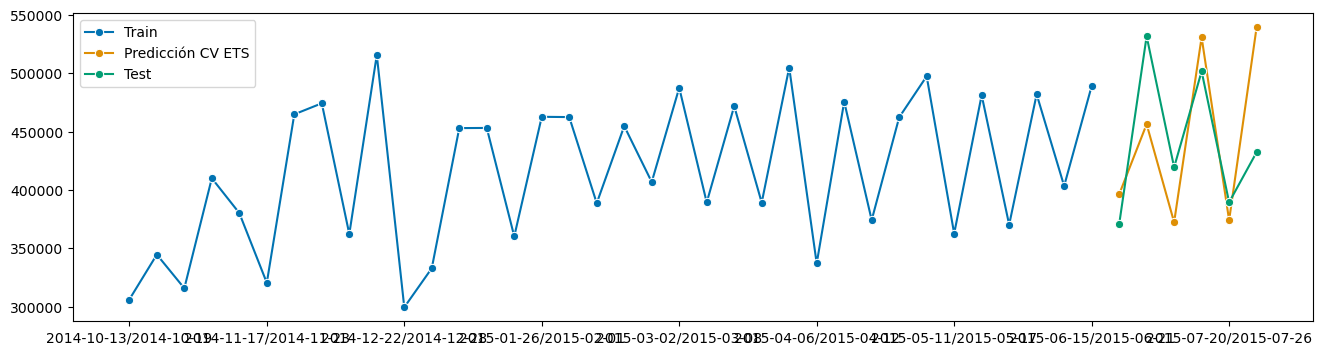

In [36]:
# Plot predictions

plot_series(ts_train[-36:], ets_cv_pred, ts_test, labels=["Train", "Predicción CV ETS", "Test"])

In [37]:
# Performance metrics forecasting

ForecastPerformance(ts_test, ets_cv_pred)

RMSE: 59312.47
MAPE: 11.14%


## 3.2 Modelo Theta

Al observar que las predicciones con el modelo ETS han sido aparentemente buenas, se estima el modelo Theta puesto que este modelo modifica el modelo ETS para que sea más robusta la tendencia (la adapta), por eso se cree que este puede ser un buen modelo y mejore al modelo ETS.

La particularidad del modelo Theta es que tiene un parámetro que se encarga de suavizar la tendencia. Dependiendo del valor que le demos a este parámetro la suavizará más o menos. En este caso, si no se especifica el valor alpha, Sktime lo estimará a partir de los datos.

In [38]:
# Inputs: transformaciones y modelos
pipe = TransformedTargetForecaster(steps=[
    ("forecaster", NaiveForecaster())])

# Cross Validation
cv = ExpandingWindowSplitter(
    initial_window=72,
     step_length=1,
     start_with_window=True,
     fh=fh_test)

# GRID Search
gscv_THETA = ForecastingGridSearchCV(
     forecaster=pipe,
    param_grid=[{
         "forecaster": [NaiveForecaster(sp=52)],
         "forecaster__strategy": ["drift", "last", "mean"],
     },
     {
          "forecaster": [ThetaForecaster(sp=52,deseasonalize=True)],
                   
    },
     ],
     cv=cv,
     verbose=1,
     n_jobs=-1)

In [39]:
# Fit THETA model

gscv_THETA.fit(ts_train)

Fitting 52 folds for each of 4 candidates, totalling 208 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6]),
                                                   initial_window=72),
                        forecaster=TransformedTargetForecaster(steps=[('forecaster',
                                                                       NaiveForecaster())]),
                        n_jobs=-1,
                        param_grid=[{'forecaster': [NaiveForecaster(sp=52)],
                                     'forecaster__strategy': ['drift', 'last',
                                                              'mean']},
                                    {'forecaster': [ThetaForecaster(sp=52)]}],
                        verbose=1)

In [40]:
# Predicción

fh_test=np.arange(1,len(ts_test)+1)
theta_pred_CV = gscv_THETA.predict(fh=fh_test)
theta_pred_CV

,Sales
2015-06-22/2015-06-28,390133.249516
2015-06-29/2015-07-05,466611.910965
2015-07-06/2015-07-12,355274.567610
2015-07-13/2015-07-19,448112.189333
2015-07-20/2015-07-26,337067.282910
2015-07-27/2015-08-02,491551.872753


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

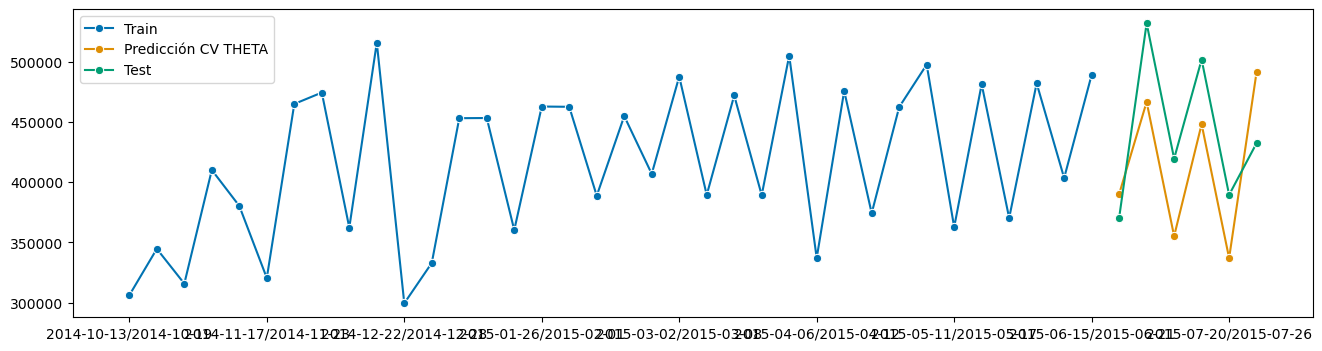

In [41]:
# Plot predictions

plot_series(ts_train[-36:], theta_pred_CV, ts_test, labels=["Train", "Predicción CV THETA", "Test"])

In [42]:
# Performance metrics forecasting

ForecastPerformance(ts_test, theta_pred_CV)

RMSE: 54592.49
MAPE: 11.78%


El MAPE del modelo Theta empeora ligeramente con respecto al modelo ETS. Se han comportado prácticamente igual en las predicciones.

### **Conclusiones**

Tabla comparativa con los resulados.

In [43]:
# Dictionary with the results
table = {'Modelo': ['ETS', 'THETA'], 'MAPE': ['11.14%','11.78%'], 'RMSE': [59312.47, 54592.49]}

# Create DataFrame
results = pd.DataFrame(table)

# Print the output.
results

,Modelo,MAPE,RMSE
0,ETS,11.14%,59312.47
1,THETA,11.78%,54592.49


El mejor modelo predictivamente hablando que se ajusta a la serie es el modelo ETS puesto que cuenta con menor porcentaje en el MAPE, aunque no cuenta con mucha ventaja con respecto al Theta.

Se muestra gráficamente la comparación de las predicciones de los tres modelos. 

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

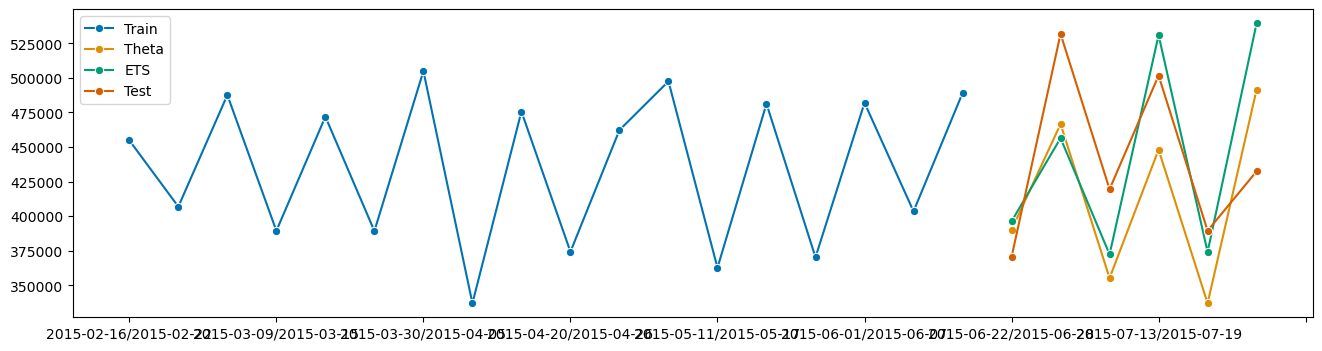

In [44]:
plot_series(ts_train[-18:], theta_pred_CV,ets_cv_pred, ts_test, 
            labels=["Train", "Theta","ETS","Test"])

Llama la atención la predicción que hace el TBATS puesto que es la única que no tiene en cuenta la tendencia. Las demás predicciones son similares pero la que mejor se ajusta al test es la del modelo ETS.

# <a name="modelo"> 4. Predicciones semanales <a>

Se calculan las predicciones utilizando el mejor **modelo ETS** estimado anteriormente mediante el grid. 

In [45]:
# Fit model

gscv_ETS.fit(total_sales_week)

Fitting 58 folds for each of 11 candidates, totalling 638 fits


ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=array([1, 2, 3, 4, 5, 6]),
                                                   initial_window=72),
                        forecaster=TransformedTargetForecaster(steps=[('forecaster',
                                                                       NaiveForecaster())]),
                        n_jobs=-1,
                        param_grid=[{'forecaster': [NaiveForecaster(sp=52)],
                                     'forecaster__strategy': ['drift', 'last',
                                                              'mean']},
                                    {'forecaster': [ExponentialSmoothing(sp=52)],
                                     'forecaster__damped_trend': [True, False],
                                     'forecaster__seasonal': ['add', 'mul'],
                                     'forecaster__trend': ['add', 'mul']}],
                        verbose=1)

Cálculo de predicciones para un horizonte temporal de 6 semanas.

In [46]:
# Predictions 

ets_pred = gscv_ETS.predict(fh=[1,2,3,4,5,6]) 
ets_pred.tail()

,Sales
2015-08-10/2015-08-16,475763.554376
2015-08-17/2015-08-23,376603.501891
2015-08-24/2015-08-30,483049.512498
2015-08-31/2015-09-06,385460.580214
2015-09-07/2015-09-13,471880.797902


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

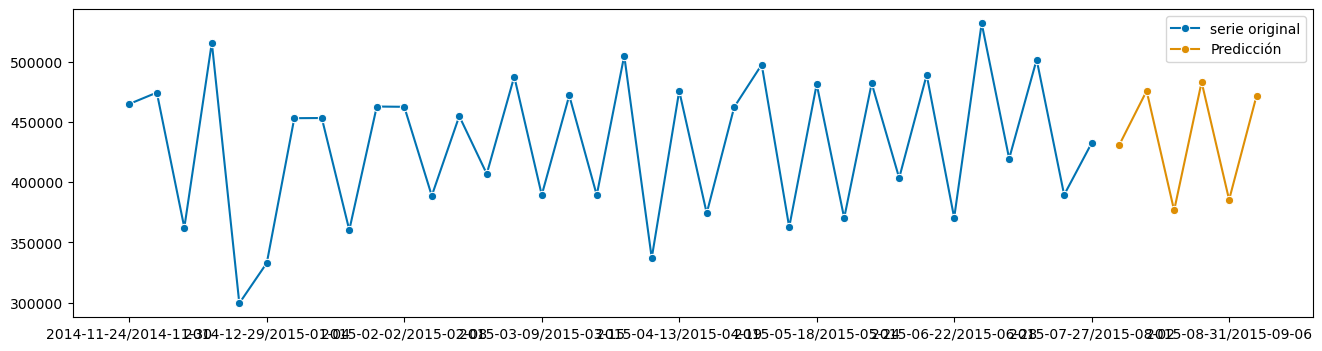

In [47]:
# Plot predictions 
plot_series(total_sales_week[-36:], ets_pred, labels=["serie original", "Predicción"])

Las ventas que se esperan no presenta ningún cambio significativo con respecto al histórico de ventas, es decir, se espera un comportamiento similar a lo que se ha observado en el pasado.

El número de ventas al tener que ser un número entero no se tendrán en cuenta los decimales.

In [48]:
final_forecast = pd.Series([round(val, 0) for val in ets_pred['Sales']])

##### Exportación de las predicciones a un fichero .csv

Se exportarán únicamente las predicciones con el valor de las ventas semanales, sin fechas ni índices. El archivo *.csv* se llamará `predicciones_semanales.csv` y se encontrará en el directorio *../data/processed*.

In [49]:
# Export to csv
final_forecast.to_csv('../data/processed/predicciones_semanales.csv', index=False)

# <a name="conclusiones"> 5. Conclusiones finales <a>

Las predicciones obtenidas con el modelo `ETS` se consideran buenas, puesto que el MAPE del modelo no es demasiado alto y además en el gráfico final de las predicciones se aprecia un resultado lógico. Probablemente las predicciones con el modelo Theta hubieran sido similares puesto que el MAPE en ambos modelos era prácticamente el mismo. 

La debilidad de estas predicciones probablemente sean que no se ajuste lo suficiente a la tendencia. 